# Digital Media Correlation on Stock Market Prices: Analyzing the Predictive Power of Reddit on S&P 500 Movements

Primary Objective:
* To evaluate how well sentiment and discussion trends from Reddit can correlate and potentially predict short-term stock market movements in S&P 500 companies.

Specific Goals:
* Collect large-scale Reddit posts and comments data that reference S&P 500 companies.
* Clean data of duplicates, irrelevant dates, and nulls in important columns
* Separate the Reddit data by company mention and compile the posts’ metrics (sentiment, comments, upvotes, etc).
* Separate S&P 500 company stock data by company.
* Conduct correlation analysis using Reddit sentiment scores and post metrics with individual company stock price changes.
* Visualize our findings using tables, graphs, and other visual aids.


## Loading in data

In [ ]:
# MAIN MODULES
import os
import pandas as pd
import numpy as np

# SPECIAL MODULES
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt

# PySpark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql import DataFrame
from pyspark.sql import DataFrame
from pyspark.sql import functions as F
from pyspark.sql.functions import lit
from pyspark.sql.functions import corr

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
#d603gp1 is main shared folder name

Mounted at /content/gdrive


In [ ]:
%cd "/content/gdrive/MyDrive/d603gp1"

/content/gdrive/.shortcut-targets-by-id/1enr5qdB-uJH68DdCgNeWX_9hB3lQUidR/d603gp1


In [ ]:
%ls

 603_project.gslides                                sp500_stocks_oct_to_feb.csv
'd603 shared gpt feedback.gdoc'                     spdf2export.csv
 Data/                                              spdf2exportINDEXtrue.csv
' FINAL Group_1_603_project_Presentation.gslides'   spdfexport.csv
'Final Project Skeleton'                            spdfexportINDEXtrue.csv
 Images/                                            spike/
 References/                                        zbkupdata/
'resources and tasks .gdoc'@


In [ ]:
%ls -lR "/content/gdrive/MyDrive/d603gp1/Data"

/content/gdrive/MyDrive/d603gp1/Data:
total 536
-rw------- 1 root root 528091 Nov 19 21:22 'Final Project Skeleton'
drwx------ 2 root root   4096 Nov  9 21:33  kaggle/
drwx------ 2 root root   4096 Nov 15 21:08  parquet/
drwx------ 2 root root   4096 Nov  9 21:33  reddit/
drwx------ 2 root root   4096 Nov 16 00:13  short_sp500_stocks.csv/
drwx------ 2 root root   4096 Nov 16 00:33  x/

/content/gdrive/MyDrive/d603gp1/Data/kaggle:
total 94891
-rw------- 1 root root   803820 Nov  9 21:15 sp500_companies.csv
-rw------- 1 root root    47607 Nov  9 21:15 sp500_index.csv
-rw------- 1 root root 96316712 Nov  9 21:15 sp500_stocks.csv

/content/gdrive/MyDrive/d603gp1/Data/parquet:
total 24
drwx------ 2 root root 4096 Nov 15 23:02 comments/
drwx------ 2 root root 4096 Nov 15 23:02 features/
drwx------ 2 root root 4096 Nov 15 23:00 meta_time_series/
drwx------ 2 root root 4096 Nov 15 21:20 sp500_companies/
drwx------ 2 root root 4096 Nov 15 21:20 sp500_index/
drwx------ 2 root root 4096 Nov 15 21

In [ ]:
########################## STEPS TAKEN FOR PROJECT ############################
# Load current directory -  we made sure we all had the same shared folder in our google drives loaded in the same root directory for consistency in running the code for anyone working on the project
#  %ls -lR "/content/gdrive/MyDrive/d603gp1/Data"  will list our actual key datafiles
# Convert CSV Files to Parquet format inside the Data folder - there are 6 CSV files inside the data folder that we need to do this.

# Cleaning Data


### Convert all .csv files to parquet format

In [ ]:
# Create Spark session
spark = SparkSession.builder.appName("Reddit_Stock_Data_Analysis").getOrCreate()

In [ ]:
def convert_csvs_to_parquet(input_dir: str, output_dir: str, delimiter = ","):

  # Loop through files in the input directory
  for filename in os.listdir(input_dir):
    print(filename)
    if filename.endswith(".csv"):
      csv_path = os.path.join(input_dir, filename)

      # Extract name without .csv
      base = os.path.splitext(filename)[0]

      # Read CSV
      df = spark.read.option("delimiter", delimiter).csv(
          csv_path,
          header=True,
          inferSchema=True,
          multiLine=False
      )

      # Write Parquet to a folder named after the csv file
      df.write.mode("overwrite").parquet(f"{output_dir}/{base}")

In [ ]:
#DO NOT RUN THIS AGAIN!! iTS ONLY MEANT TO BE RUN ONCE TO CONVERT FILES TO PARQUET FORMAT ONCE
#convert_csvs_to_parquet(input_dir="/content/gdrive/MyDrive/d603gp1/Data/kaggle", output_dir="/content/gdrive/MyDrive/d603gp1/Data/parquet")
#convert_csvs_to_parquet(input_dir="/content/gdrive/MyDrive/d603gp1/Data/reddit", output_dir="/content/gdrive/MyDrive/d603gp1/Data/parquet", delimiter=";")

### Check that the parquet files were converted correctly and display the right data/schemas

In [ ]:
parquet_root = "/content/gdrive/MyDrive/d603gp1/Data/parquet"

# Loop through subfolders
for folder in os.listdir(parquet_root):
    folder_path = os.path.join(parquet_root, folder)

    # Check if folder is parquet folder, then print info
    if os.path.isdir(folder_path):
        print(f"\nDataset: {folder}")
        df = spark.read.parquet(folder_path)

        print("\nSchema:")
        df.printSchema()

        print("\nFirst 5 rows:")
        df.show(5, truncate=False)

        print(f"Total rows: {df.count()}")



Dataset: sp500_stocks

Schema:
root
 |-- Date: date (nullable = true)
 |-- Symbol: string (nullable = true)
 |-- Adj Close: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Open: double (nullable = true)
 |-- Volume: double (nullable = true)


First 5 rows:
+----------+------+------------------+------------------+------------------+------------------+------------------+---------+
|Date      |Symbol|Adj Close         |Close             |High              |Low               |Open              |Volume   |
+----------+------+------------------+------------------+------------------+------------------+------------------+---------+
|2024-09-16|IFF   |102.7579345703125 |103.63999938964844|104.68000030517578|102.9000015258789 |104.12999725341797|898500.0 |
|2024-09-17|IFF   |103.33300018310547|104.22000122070312|104.41000366210938|103.45999908447266|104.05000305175781|945600.0 |
|2024-09-18|IFF   |102.5794

### Load in the parquet files as Spark dataframes

In [ ]:
reddit_meta_time_series_df = spark.read.parquet("/content/gdrive/MyDrive/d603gp1/Data/parquet/meta_time_series")
reddit_features_df = spark.read.parquet("/content/gdrive/MyDrive/d603gp1/Data/parquet/features")
reddit_comments_df = spark.read.parquet("/content/gdrive/MyDrive/d603gp1/Data/parquet/comments")
sp500_companies_df = spark.read.parquet("/content/gdrive/MyDrive/d603gp1/Data/parquet/sp500_companies")
sp500_index_df = spark.read.parquet("/content/gdrive/MyDrive/d603gp1/Data/parquet/sp500_index")
sp500_stocks_df = spark.read.parquet("/content/gdrive/MyDrive/d603gp1/Data/parquet/sp500_stocks")

In [ ]:
all_dataframes = [reddit_meta_time_series_df, reddit_features_df, reddit_comments_df, sp500_companies_df, sp500_index_df, sp500_stocks_df]

In [ ]:
reddit_meta_time_series_df.show(5, truncate=False)

+----------------------------------------------------------------+----------+------------+-----+------------+--------------------------+
|submission_id                                                   |crossposts|num_comments|score|upvote_ratio|timestamp                 |
+----------------------------------------------------------------+----------+------------+-----+------------+--------------------------+
|67b5c63d16209fb04499b2cdf1d3053e0f04ef85440ad6e80fc58191d69ab524|0.0       |40.0        |171.0|0.9         |2021-11-21 16:26:34.635979|
|7258e459a8aa264a519f8c8376ed603270417ea7a92f16364f24a7304b6cffc2|1.0       |122.0       |824.0|0.98        |2021-11-21 16:26:34.375517|
|4d22700c0828594c9e3aa9d256dd0a2dd294b40b61f8abb6ec9cad586529aa8d|0.0       |3.0         |19.0 |1.0         |2021-11-21 16:26:34.276455|
|70e0b1d0d5864ecee31e09b35264c70beb94ea9685f7a8a47e6f7080182b9d54|0.0       |47.0        |114.0|0.84        |2021-11-21 16:26:34.116487|
|b5f0e68196026c62646ed6a0f9bb6ed89e02dff0

### Extract date from timestamps in Reddit Data

In [ ]:
def extract_date_from_timestamp(df: DataFrame) -> DataFrame:
  return df.withColumn("date", col('timestamp').cast("date"))

reddit_features_df = extract_date_from_timestamp(reddit_features_df)
reddit_meta_time_series_df = extract_date_from_timestamp(reddit_meta_time_series_df)
reddit_comments_df = extract_date_from_timestamp(reddit_comments_df)

In [ ]:
reddit_comments_df.columns

['submission_id',
 'comment_long',
 'comment_gain',
 'comment_loss',
 'comment_short',
 'comment_shares_reference',
 'comment_total_score',
 'comment_normal_sentiment_negative_weighted',
 'comment_normal_sentiment_positive_weighted',
 'comment_total_sentiment',
 'timestamp',
 'posted_at',
 'date']

### Limit date in the kaggle dataframes from October 1st 2021 - February 25th 2022 (Same range as Reddit Data)

In [ ]:
def filter_date(df: DataFrame, start_date: str, end_date: str):
  df_sorted = df.orderBy("date")
  return df_sorted.filter((F.col("date") >= lit(start_date)) & (F.col("date") <= lit(end_date)))


In [ ]:
start_date = "2021-09-30" # We need the date before Oct 1st to get the percent change score
end_date = "2022-02-25"

sp500_stocks_df_filtered = filter_date(sp500_stocks_df, start_date, end_date)
sp500_index_df_filtered = filter_date(sp500_index_df, start_date, end_date)

In [ ]:
sp500_stocks_df_filtered.show(5, truncate=False)

+----------+------+------------------+------------------+------------------+------------------+------------------+---------+
|Date      |Symbol|Adj Close         |Close             |High              |Low               |Open              |Volume   |
+----------+------+------------------+------------------+------------------+------------------+------------------+---------+
|2021-09-30|IPG   |NULL              |NULL              |NULL              |NULL              |NULL              |NULL     |
|2021-09-30|AOS   |57.673152923583984|61.06999969482422 |64.19999694824219 |61.02000045776367 |63.75             |2082700.0|
|2021-09-30|INTU  |NULL              |NULL              |NULL              |NULL              |NULL              |NULL     |
|2021-09-30|ABT   |111.2437744140625 |118.12999725341797|120.66999816894531|118.0999984741211 |119.86000061035156|4786200.0|
|2021-09-30|IP    |46.00248336791992 |52.95454406738281 |54.441287994384766|52.897727966308594|54.412879943847656|3046771.0|


### Remove any nulls and duplicates

In [ ]:
def remove_nulls_duplicates(df: DataFrame, important_cols: list[str] = []) -> DataFrame:
  print(f"Row count for {df} before removing nulls/duplicates: ", df.count())
  if not important_cols:
    df = df.dropna(how="all").dropDuplicates()
  else:
    df = df.dropna(subset=important_cols).dropDuplicates(subset=important_cols)
  print("Row count after removing nulls/duplicates: ", df.count())
  return df

In [ ]:
# This shows there are no completely empty rows or duplicatess
for df in all_dataframes:
  df = remove_nulls_duplicates(df)

Row count for DataFrame[submission_id: string, crossposts: double, num_comments: double, score: double, upvote_ratio: double, timestamp: timestamp] before removing nulls/duplicates:  19546724
Row count after removing nulls/duplicates:  19546724
Row count for DataFrame[bear_score: double, num_bearish: double, bull_score: double, num_bullish: double, is_long: int, colour_scheme: string, flair: string, gain_score_per: double, gain_score_real: double, type_post_content: string, loss_score_per: double, loss_score_real: double, normal_sentiment_weighted: double, normal_sentiment_score_negative: double, normal_sentiment_score_positive: double, posted_at: timestamp, is_short: int, num_shares_mentions: double, social_media_type: string, submission_id: string, ticker: string, timestamp: timestamp] before removing nulls/duplicates:  237233
Row count after removing nulls/duplicates:  237233
Row count for DataFrame[submission_id: string, comment_long: double, comment_gain: double, comment_loss: dou

### Remove rows with nulls and duplicates in the "important" columns

In [ ]:
sp500_stocks_df_cleaned = remove_nulls_duplicates(sp500_stocks_df_filtered, ["Open", "Close"])
sp500_index_df_cleaned = remove_nulls_duplicates(sp500_index_df_filtered, ["S&P500"])
sp500_companies_df_cleaned = remove_nulls_duplicates(sp500_companies_df, ["Symbol"])
reddit_meta_time_series_df_cleaned = remove_nulls_duplicates(reddit_meta_time_series_df, ["num_comments", "score"])
reddit_features_df_cleaned = remove_nulls_duplicates(reddit_features_df, ["normal_sentiment_weighted", "bear_score", "bull_score"])
reddit_comments_df_cleaned = remove_nulls_duplicates(reddit_comments_df, ["comment_total_score"])

Row count for DataFrame[Date: date, Symbol: string, Adj Close: double, Close: double, High: double, Low: double, Open: double, Volume: double] before removing nulls/duplicates:  51706
Row count after removing nulls/duplicates:  17489
Row count for DataFrame[Date: date, S&P500: double] before removing nulls/duplicates:  103
Row count after removing nulls/duplicates:  103
Row count for DataFrame[Exchange: string, Symbol: string, Shortname: string, Longname: string, Sector: string, Industry: string, Currentprice: string, Marketcap: string, Ebitda: string, Revenuegrowth: string, City: string, State: string, Country: string, Fulltimeemployees: string, Longbusinesssummary: string, Weight: string] before removing nulls/duplicates:  503
Row count after removing nulls/duplicates:  503
Row count for DataFrame[submission_id: string, crossposts: double, num_comments: double, score: double, upvote_ratio: double, timestamp: timestamp, date: date] before removing nulls/duplicates:  19546724
Row count

In [ ]:
sp500_stocks_df_filtered.show(5, truncate=False)

+----------+------+------------------+------------------+------------------+------------------+------------------+---------+
|Date      |Symbol|Adj Close         |Close             |High              |Low               |Open              |Volume   |
+----------+------+------------------+------------------+------------------+------------------+------------------+---------+
|2021-09-30|IPG   |NULL              |NULL              |NULL              |NULL              |NULL              |NULL     |
|2021-09-30|AOS   |57.673152923583984|61.06999969482422 |64.19999694824219 |61.02000045776367 |63.75             |2082700.0|
|2021-09-30|INTU  |NULL              |NULL              |NULL              |NULL              |NULL              |NULL     |
|2021-09-30|ABT   |111.2437744140625 |118.12999725341797|120.66999816894531|118.0999984741211 |119.86000061035156|4786200.0|
|2021-09-30|IP    |46.00248336791992 |52.95454406738281 |54.441287994384766|52.897727966308594|54.412879943847656|3046771.0|


# Preprocessing Data for Analysis

### Calculate percent change between open and close for each date in the sp500_stocks dataframe

In [ ]:
from pyspark.sql import functions as F

sp500_stocks_df_with_pct = (
    sp500_stocks_df_cleaned.withColumn(
        "Price Percent Change",
        F.when(F.col("Open") != 0,
               ((F.col("Close") - F.col("Open")) / F.col("Open")) * 100
        ).otherwise(None)
    )
)

# We no longer need data from 9-30-2021, so we can filter dates to the actual date range
sp500_stocks_df_with_pct = filter_date(sp500_stocks_df_with_pct, "2021-10-01", "2022-02-25")
sp500_stocks_df_with_pct.orderBy(["Symbol", "Date"]).show()

+----------+------+-----------------+------------------+------------------+------------------+------------------+---------+--------------------+
|      Date|Symbol|        Adj Close|             Close|              High|               Low|              Open|   Volume|Price Percent Change|
+----------+------+-----------------+------------------+------------------+------------------+------------------+---------+--------------------+
|2021-10-01|  ABBV|96.19676208496094|109.08999633789062|109.69000244140625|106.87000274658203|            108.25|8611500.0|  0.7759781412384527|
|2021-10-04|  ABBV|95.87931823730469| 108.7300033569336|110.19999694824219|107.69000244140625|108.83999633789062|9779200.0|-0.10105933908299777|
|2021-10-05|  ABBV|96.56712341308594|109.51000213623047|110.58000183105469| 109.0999984741211|109.38999938964844|7146900.0| 0.10970175267537947|
|2021-10-06|  ABBV|96.39956665039062|109.31999969482422|109.66999816894531| 108.1500015258789|109.30000305175781|5710300.0| 0.0182

### Calculate percent change of S&P 500 index from the current day and the day before

In [ ]:
from pyspark.sql import functions as F
from pyspark.sql import Window

w = Window.orderBy("Date")

# Get the previous day's S&P500 value
sp500_index_df_cleaned = sp500_index_df_cleaned.withColumn(
    "Prev_S&P500",
    F.lag("S&P500").over(w)
)

# Percent Change = ((S&P500 - Prev_S&P500) / Prev_S&P500) * 100
sp500_index_df_with_pct = sp500_index_df_cleaned.withColumn(
    "Index Percent Change",
    F.when(
        F.col("Prev_S&P500").isNotNull(),
        ((F.col("S&P500") - F.col("Prev_S&P500")) / F.col("Prev_S&P500")) * 100
    ).otherwise(None)
)

# We no longer need data from 9-30-2021, so we can filter dates to the  actual range
sp500_index_df_with_pct = filter_date(sp500_index_df_with_pct, "2021-10-01", "2022-02-25")
sp500_index_df_with_pct.show()

+----------+-------+-----------+--------------------+
|      Date| S&P500|Prev_S&P500|Index Percent Change|
+----------+-------+-----------+--------------------+
|2021-10-01|4357.04|    4307.54|  1.1491477734391324|
|2021-10-04|4300.46|    4357.04|  -1.298588032242071|
|2021-10-05|4345.72|    4300.46|  1.0524455523362668|
|2021-10-06|4363.55|    4345.72|  0.4102887438675277|
|2021-10-07|4399.76|    4363.55|  0.8298289236974489|
|2021-10-08|4391.34|    4399.76|-0.19137407494954434|
|2021-10-11|4361.19|    4391.34|  -0.686578584213487|
|2021-10-12|4350.65|    4361.19|-0.24167715692276567|
|2021-10-13| 4363.8|    4350.65|  0.3022536862308057|
|2021-10-14|4438.26|     4363.8|  1.7063110133370005|
|2021-10-15|4471.37|    4438.26|  0.7460130771969121|
|2021-10-18|4486.46|    4471.37| 0.33748045900921075|
|2021-10-19|4519.63|    4486.46|  0.7393356900540754|
|2021-10-20|4536.19|    4519.63| 0.36640167447334165|
|2021-10-21|4549.78|    4536.19|  0.2995906256131279|
|2021-10-22| 4544.9|    4549

### Group Reddit data by date and company aggregate metrics for measuring sentiment as well as engagement with the post (number of comments, upvotes, etc)

In [ ]:
from pyspark.sql import functions as F
from pyspark.sql.functions import explode, udf, trim, col
from pyspark.sql.types import ArrayType, StringType
import ast

# Get unique S&P 500 symbols from sp500_companies_df for filtering
sp500_symbols_list = sp500_companies_df_cleaned.select("Symbol").distinct().rdd.map(lambda row: row.Symbol).collect()
sp500_symbols_broadcast = spark.sparkContext.broadcast(sp500_symbols_list)

# Function to parse post contents into a list and filter for valid S&P 500 symbols
def parse_and_filter_tickers(ticker_string):
    if not ticker_string:
        return []
    try:
        # Evaluate the string as a Python literal ("['MSFT']" -> ['MSFT'])
        ticker_list = ast.literal_eval(ticker_string)
        if not isinstance(ticker_list, list):
            return []

        # Filter for non-empty, non-common word tickers, convert to uppercase, and check against S&P 500 list
        valid_tickers = [
            t.strip().upper() for t in ticker_list
            if t and len(t.strip()) > 1 and len(t.strip()) <= 5  # Basic length filter for symbols
            and t.strip().upper() in sp500_symbols_broadcast.value # Check against actual S&P 500 symbols
        ]
        return list(set(valid_tickers))
    except (ValueError, SyntaxError):
        # Handle cases where the string is not a valid list literal (e.g., malformed data)
        return []

parse_ticker_udf = udf(parse_and_filter_tickers, ArrayType(StringType()))



In [ ]:
# Join reddit_features_df with reddit_meta_time_series_df
reddit_joined_df = reddit_features_df_cleaned.join(
    reddit_meta_time_series_df.select('submission_id', 'date', 'num_comments', 'score'),
    on=['submission_id', 'date'],
    how='inner'
)

# Use the previously defined function to parse ticker strings to array, then explode into separate rows
reddit_df_with_exploded_tickers = reddit_joined_df.withColumn(
    "Symbol_Array", parse_ticker_udf(col("ticker"))
).withColumn(
    "Symbol", explode(col("Symbol_Array"))
).filter(col("Symbol").isNotNull()) # Filter out rows where no valid symbol was extracted

# Select and rename columns to match the aggregation requirements
reddit_df_for_agg = reddit_df_with_exploded_tickers.select(
    col("date").alias("Date"),
    col("Symbol"),
    col("bear_score"),
    col("bull_score"),
    col("normal_sentiment_weighted").alias("sentiment"),
    col("num_comments"),
    col("score").alias("upvotes") # Using 'score' as upvotes
)

# Perform the aggregation by day
reddit_daily_agg = (
    reddit_df_for_agg
    .groupBy("Date", "Symbol")
    .agg(
        F.avg("sentiment").alias("avg_sentiment"), # average sentiment for that stock on that date
        F.avg("bear_score").alias("avg_bear_score"), # average bear_score for that stock on that date
        F.avg("bull_score").alias("avg_bull_score"), # average bull_score for that stock on that date
        F.count("Symbol").alias("num_posts"), # number of Reddit posts for a symbol on a date
        F.sum("num_comments").alias("num_comments"), # total comments across posts
        F.sum("upvotes").alias("total_upvotes") # total upvotes/score
    )
)

### Calculate the average sentiment of the company for the day prior

In [ ]:
from pyspark.sql import Window
from pyspark.sql.functions import col, lag

w = Window.partitionBy("Symbol").orderBy("Date")
reddit_daily_agg = reddit_daily_agg.withColumn("avg_sentiment_day_before", lag(col("avg_sentiment")).over(w) )

In [ ]:
reddit_daily_agg.orderBy(["Symbol", "Date"]).show(5)

+----------+------+-------------------+--------------+--------------+---------+------------+-------------+------------------------+
|      Date|Symbol|      avg_sentiment|avg_bear_score|avg_bull_score|num_posts|num_comments|total_upvotes|avg_sentiment_day_before|
+----------+------+-------------------+--------------+--------------+---------+------------+-------------+------------------------+
|2021-11-21|  AAPL|             0.8202|           0.0|           0.0|       21|       126.0|         65.0|                    NULL|
|2021-11-22|  AAPL| 0.5713000000000004|           0.0|           0.0|       27|       477.0|       2475.0|                  0.8202|
|2021-11-23|  AAPL| 0.6996000000000001|           1.0|           0.0|       15|        22.0|        120.0|      0.5713000000000004|
|2021-12-01|  AAPL| 0.5513000000000001|           1.0|           0.0|       11|       411.0|       1799.0|      0.6996000000000001|
|2021-12-02|  AAPL|-0.7639999999999996|           0.0|           0.0|       

### Join Reddit Data with Actual Stock Data for the same company on the same day to allow for analysis

In [ ]:
from pyspark.sql import functions as F

reddit_stocks = (
    reddit_daily_agg.alias("r")
    .join(
        sp500_stocks_df_with_pct.alias("s"),
        on=["Date", "Symbol"],
        how="inner"
    )
    .join(
        sp500_index_df_with_pct.alias("i"),
        on=["Date"],
        how="inner",
    )
    .drop("Prev_S&P500", "Adj Close", "Close", "High", "Low", "Open", "Volume") # drop columns we will not look at directly
)

reddit_stocks.show(5)

+----------+------+-------------------+-------------------+--------------+---------+------------+-------------+------------------------+--------------------+-------+--------------------+
|      Date|Symbol|      avg_sentiment|     avg_bear_score|avg_bull_score|num_posts|num_comments|total_upvotes|avg_sentiment_day_before|Price Percent Change| S&P500|Index Percent Change|
+----------+------+-------------------+-------------------+--------------+---------+------------+-------------+------------------------+--------------------+-------+--------------------+
|2021-12-01|   ABT| 0.8589000000000001|                0.0|           0.0|       15|        15.0|         11.0|                    NULL| 0.20556174884200354|4513.04|  -1.181519597109701|
|2021-12-02|   AMP| -0.546498058252426|0.39805825242718446|           0.0|      103|      3158.0|       2330.0|     -0.5989947368421027|  2.8084762702238613| 4577.1|  1.4194423271231897|
|2021-11-24|  AMZN| 0.5753999999999992|                1.0|      

### Define the "Effective" Sentiment for the day
This tells us which sentiment (today or yesterday's) before made more of an impact on stock price change that day

In [ ]:
from pyspark.sql import functions as F

# calculate which sentiment (today or yesterday's) is closest to price change
reddit_stocks = reddit_stocks.withColumn(
    "error_today",
    F.abs(F.col("Price Percent Change") - F.col("avg_sentiment"))
).withColumn(
    "error_yest",
    F.when(
      F.col("avg_sentiment_day_before").isNull(),
      F.lit(9999) # huge penalty so yesterday doesnt count if its null
    ).otherwise(
      F.abs(F.col("Price Percent Change") - F.col("avg_sentiment_day_before"))
    )
)

reddit_stocks = reddit_stocks.withColumn(
    "closest_sentiment",
    F.when(F.col("error_today") < F.col("error_yest"), "today")
     .when(F.col("error_yest") < F.col("error_today"), "yesterday")
     .otherwise("tie")
).drop("error_today", "error_yest")

reddit_stocks = reddit_stocks.withColumn(
    "effective_sentiment",
    F.when(F.col("closest_sentiment") == "today", F.col("avg_sentiment"))
     .when(F.col("closest_sentiment") == "yesterday", F.col("avg_sentiment_day_before"))
     .otherwise((F.col("avg_sentiment") + F.col("avg_sentiment_day_before")) / 2)
)

# Correlations

### Correlation between Reddit metrics and actual price change over all companies

In [ ]:
corr_sentiment_percent_change = reddit_stocks.corr("avg_sentiment", "Price Percent Change")
corr_prior_sentiment_percent_change = reddit_stocks.corr("avg_sentiment_day_before", "Price Percent Change")
corr_effective_sentiment_percent_change = reddit_stocks.stat.corr("effective_sentiment", "Price Percent Change")
corr_bear_score_percent_change = reddit_stocks.corr("avg_bear_score", "Price Percent Change")
corr_bull_score_percent_change = reddit_stocks.corr("avg_bull_score", "Price Percent Change")
corr_posts_percent_change = reddit_stocks.corr("num_posts", "Price Percent Change")
corr_upvotes_percent_change = reddit_stocks.corr("total_upvotes", "Price Percent Change")

print("Correlation: Current Day's Sentiment vs Actual Price Percent Change =", corr_sentiment_percent_change)
print("Correlation: Prior Day's Sentiment vs Actual Price Percent Change =", corr_prior_sentiment_percent_change)
print("Correlation: Effective Sentiment vs Actual Price Percent Change =", corr_effective_sentiment_percent_change)
print("Correlation: Bear Score vs Actual Price Percent Change =", corr_bear_score_percent_change)
print("Correlation: Bull Score vs Actual Price Percent Change =", corr_bull_score_percent_change)
print("Correlation: Num Posts vs Actual Price Percent Change =", corr_posts_percent_change)
print("Correlation: Upvotes vs Actual Price Percent Change =", corr_upvotes_percent_change)


Correlation: Current Day's Sentiment vs Actual Price Percent Change = 0.0547871228086145
Correlation: Prior Day's Sentiment vs Actual Price Percent Change = -0.10184063882147754
Correlation: Effective Sentiment vs Actual Price Percent Change = 0.31841530815995633
Correlation: Bear Score vs Actual Price Percent Change = 0.05697721959341732
Correlation: Bull Score vs Actual Price Percent Change = 0.09747321888418731
Correlation: Num Posts vs Actual Price Percent Change = 0.0011727860748010994
Correlation: Upvotes vs Actual Price Percent Change = -0.039155383252996744


### Correlation between Reddit metrics and actual price change grouped by company

In [ ]:
from pyspark.sql.functions import corr

corr_by_company_df = (
    reddit_stocks
        .groupBy("Symbol")
        .agg(
            corr("avg_sentiment", "Price Percent Change").alias("corr_sentiment_percent_change"),
            corr("avg_sentiment_day_before", "Price Percent Change").alias("corr_prior_sentiment_percent_change"),
            corr("effective_sentiment", "Price Percent Change").alias("corr_effective_sentiment_percent_change"),
            corr("avg_bear_score", "Price Percent Change").alias("corr_bear_score_percent_change"),
            corr("avg_bull_score", "Price Percent Change").alias("corr_bull_score_percent_change"),
            corr("num_posts", "Price Percent Change").alias("corr_posts_percent_change"),
            corr("total_upvotes", "Price Percent Change").alias("corr_upvotes_percent_change")
        )
)

In [ ]:
corr_by_company_df.orderBy("corr_sentiment_percent_change", ascending=False).show(5)

+------+-----------------------------+-----------------------------------+---------------------------------------+------------------------------+------------------------------+-------------------------+---------------------------+
|Symbol|corr_sentiment_percent_change|corr_prior_sentiment_percent_change|corr_effective_sentiment_percent_change|corr_bear_score_percent_change|corr_bull_score_percent_change|corr_posts_percent_change|corr_upvotes_percent_change|
+------+-----------------------------+-----------------------------------+---------------------------------------+------------------------------+------------------------------+-------------------------+---------------------------+
|  MSFT|                          1.0|                -1.0000000000000002|                                   NULL|                          -1.0|                          NULL|                      1.0|        -1.0000000000000002|
|    PM|            0.446578818341413|                 0.3654913072710517|  

In [ ]:
corr_by_company_df.orderBy("corr_prior_sentiment_percent_change", ascending=False).show(5)

+------+-----------------------------+-----------------------------------+---------------------------------------+------------------------------+------------------------------+-------------------------+---------------------------+
|Symbol|corr_sentiment_percent_change|corr_prior_sentiment_percent_change|corr_effective_sentiment_percent_change|corr_bear_score_percent_change|corr_bull_score_percent_change|corr_posts_percent_change|corr_upvotes_percent_change|
+------+-----------------------------+-----------------------------------+---------------------------------------+------------------------------+------------------------------+-------------------------+---------------------------+
|  UBER|          0.06871748502929408|                                1.0|                     0.8123765972801952|            0.8123765972801951|                          NULL|       0.7261501265562635|        0.32236656679759196|
|  AMZN|          0.03194785930207836|                 0.8186798903244072|  

In [ ]:
corr_by_company_df.orderBy("corr_effective_sentiment_percent_change", ascending=False).show(5)


+------+-----------------------------+-----------------------------------+---------------------------------------+------------------------------+------------------------------+-------------------------+---------------------------+
|Symbol|corr_sentiment_percent_change|corr_prior_sentiment_percent_change|corr_effective_sentiment_percent_change|corr_bear_score_percent_change|corr_bull_score_percent_change|corr_posts_percent_change|corr_upvotes_percent_change|
+------+-----------------------------+-----------------------------------+---------------------------------------+------------------------------+------------------------------+-------------------------+---------------------------+
|  AMZN|          0.03194785930207836|                 0.8186798903244072|                     0.8862126535066613|           0.31810491088857296|            0.7423246165767329|       0.8883084847976499|         0.5814148781831735|
|  UBER|          0.06871748502929408|                                1.0|  

In [ ]:
reddit_stocks.filter(reddit_stocks.Symbol == "META").show(5)

+----------+------+-------------------+-------------------+--------------+---------+------------+-------------+------------------------+--------------------+-------+--------------------+-----------------+-------------------+
|      Date|Symbol|      avg_sentiment|     avg_bear_score|avg_bull_score|num_posts|num_comments|total_upvotes|avg_sentiment_day_before|Price Percent Change| S&P500|Index Percent Change|closest_sentiment|effective_sentiment|
+----------+------+-------------------+-------------------+--------------+---------+------------+-------------+------------------------+--------------------+-------+--------------------+-----------------+-------------------+
|2021-11-24|  META|  0.602723333333332|0.43333333333333335|           0.0|      150|      6420.0|       1389.0|     0.12860624999999964|   1.505951654343378|4701.46| 0.22939006971241432|            today|  0.602723333333332|
|2021-11-26|  META| 0.4012389473684215|0.35789473684210527|           0.0|       95|      1540.0|   

### Correlation between S&P 500 Index Percent Change and Average Sentiment for all S&P 500 companies

In [ ]:
from pyspark.sql.functions import first
from pyspark.sql.functions import avg

all_companies_daily_sentiment_df = (
    reddit_stocks
        .groupBy("date")
        .agg(
            avg("effective_sentiment").alias("all_companies_effective_sentiment"),
            first("Index Percent Change").alias("Index Percent Change")
        )
)

corr_all_companies_sentiment = all_companies_daily_sentiment_df.stat.corr("all_companies_effective_sentiment", "Index Percent Change")
print("Correlation between average effective sentiment of all companies and S&P 500 Index Percent Change:", corr_all_companies_sentiment)

Correlation between average effective sentiment of all companies and S&P 500 Index Percent Change: 0.3552081402773763


# Visualization

In [ ]:
# To do visualization easier, we converted spark dataframe to pandas dataframe
pandas_reddit_stocks_df = reddit_stocks.toPandas()

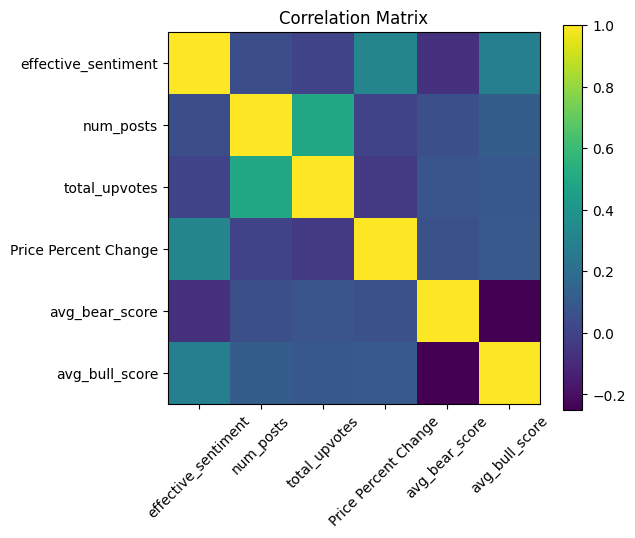

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

corr = pandas_reddit_stocks_df[["effective_sentiment", "num_posts","total_upvotes","Price Percent Change", "avg_bear_score", "avg_bull_score"]].corr()

fig, ax = plt.subplots(figsize=(6,5))

im = ax.imshow(corr)

ax.set_xticks(np.arange(len(corr.columns)))
ax.set_yticks(np.arange(len(corr.columns)))
ax.set_xticklabels(corr.columns, rotation=45)
ax.set_yticklabels(corr.columns)

plt.title("Correlation Matrix")
plt.colorbar(im)
plt.show()


### Effective Reddit Sentiment vs Actual Price Percent Change



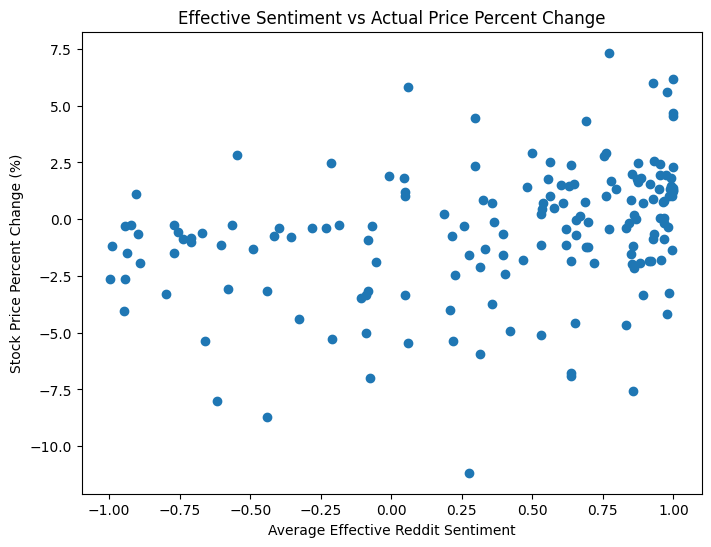

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(pandas_reddit_stocks_df["effective_sentiment"], pandas_reddit_stocks_df["Price Percent Change"])
plt.xlabel("Average Effective Reddit Sentiment")
plt.ylabel("Stock Price Percent Change (%)")
plt.title("Effective Sentiment vs Actual Price Percent Change")
plt.show()


### Bear Score vs Actual Price Percent Change

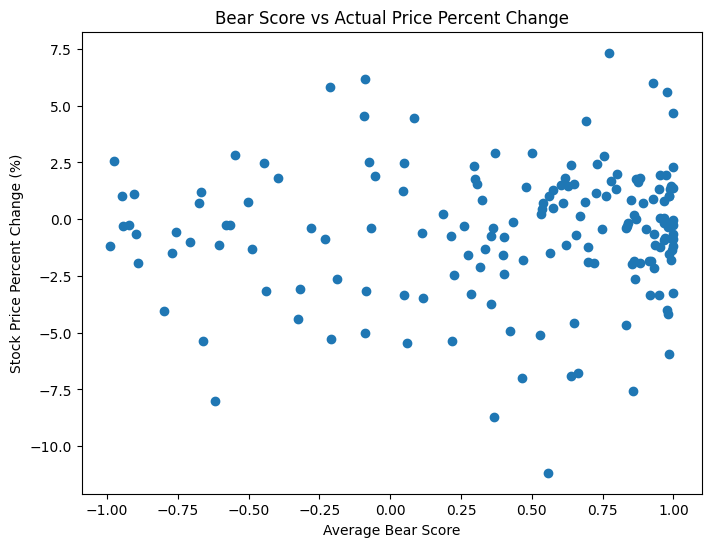

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(pandas_reddit_stocks_df["avg_sentiment"], pandas_reddit_stocks_df["Price Percent Change"])
plt.xlabel("Average Bear Score")
plt.ylabel("Stock Price Percent Change (%)")
plt.title("Bear Score vs Actual Price Percent Change")
plt.show()

### Number of Posts vs Actual Price Percent Change

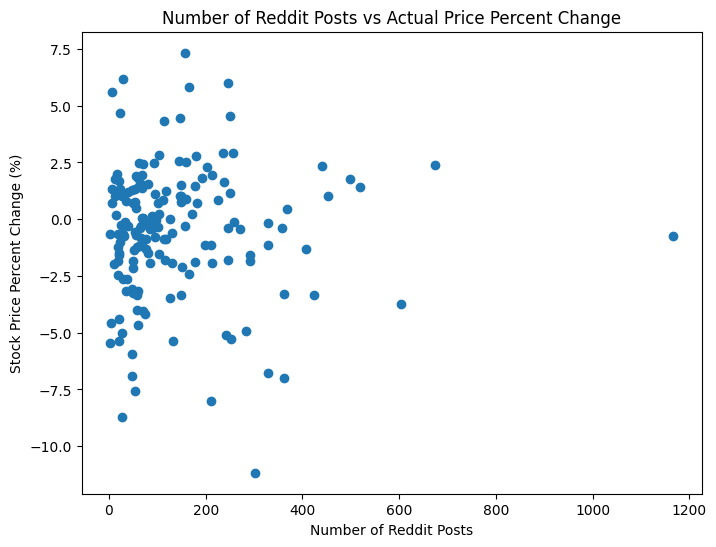

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(pandas_reddit_stocks_df["num_posts"], pandas_reddit_stocks_df["Price Percent Change"])
plt.xlabel("Number of Reddit Posts")
plt.ylabel("Stock Price Percent Change (%)")
plt.title("Number of Reddit Posts vs Actual Price Percent Change")
plt.show()


### Effective Sentiment vs Actual Price Percent Change by Company (Top 8)



Top 8 companies: ['AMZN', 'UBER', 'PM', 'META', 'GOOG', 'TSLA', 'CAT', 'NVDA']


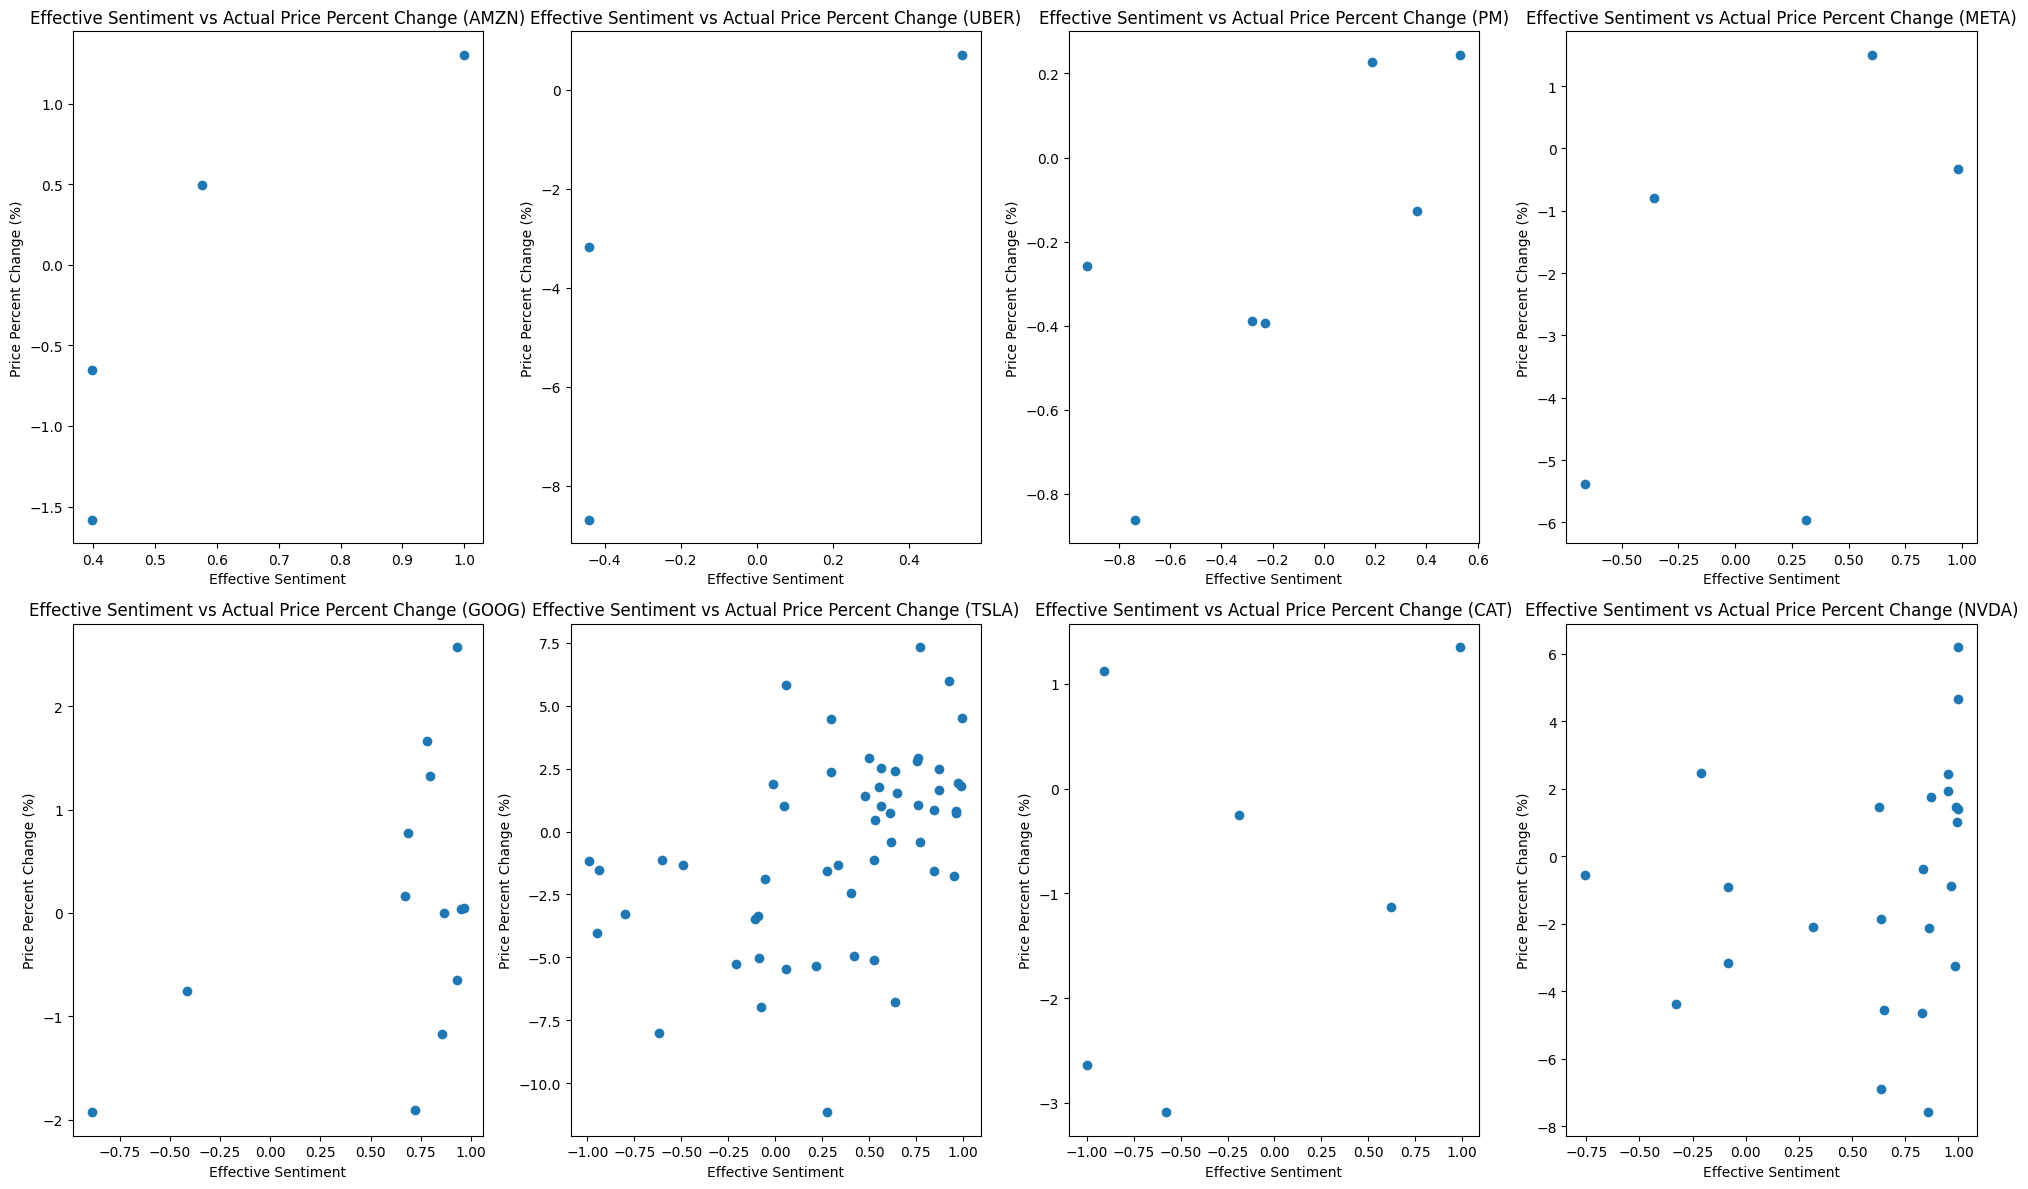

In [ ]:
# Find 8 companies with the highest sentiment percent change correlation
top8_rows = (
    corr_by_company_df
        .select("Symbol", "corr_effective_sentiment_percent_change")
        .orderBy("corr_effective_sentiment_percent_change", ascending=False)
        .limit(8)
        .collect()
)
top8_companies = [row["Symbol"] for row in top8_rows]

print("Top 8 companies:", top8_companies)

# Creating subplots for each of the 8 companies
plt.figure(figsize=(20, 12))

for i, company in enumerate(top8_companies):
    subset = pandas_reddit_stocks_df[pandas_reddit_stocks_df["Symbol"] == company]
    plt.subplot(2, 4, i + 1)
    plt.title(f"Effective Sentiment vs Actual Price Percent Change ({company})")
    plt.scatter(subset["effective_sentiment"], subset["Price Percent Change"])

    plt.xlabel("Effective Sentiment")
    plt.ylabel("Price Percent Change (%)")

plt.tight_layout()
plt.show()


### Index Percent Change of the S&P 500

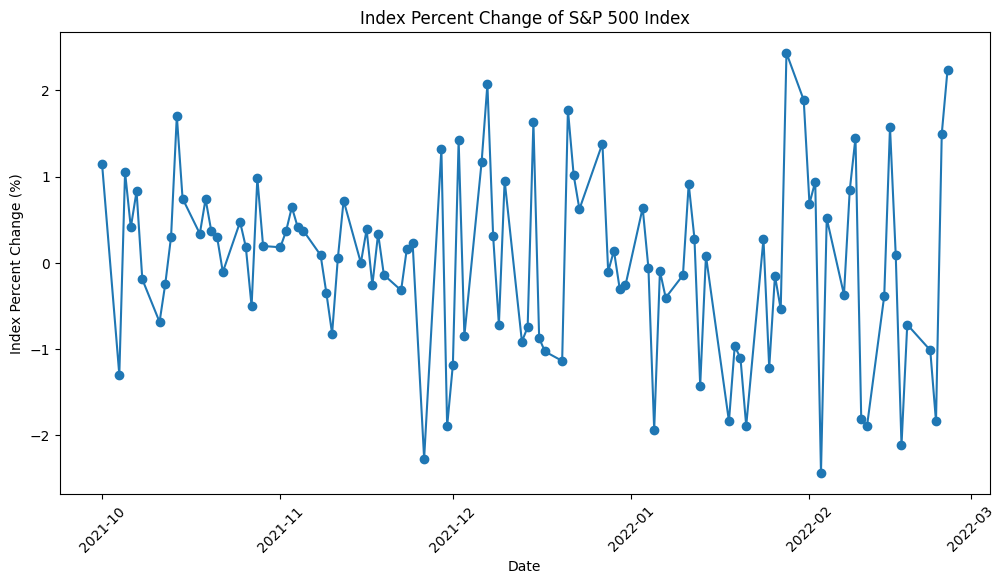

In [ ]:
index_pandas_df = sp500_index_df_with_pct.toPandas()
plt.figure(figsize=(12,6))
plt.plot(index_pandas_df['Date'], index_pandas_df['Index Percent Change'], marker='o')
plt.xlabel("Date")
plt.ylabel("Index Percent Change (%)")
plt.title("Index Percent Change of S&P 500 Index")
plt.xticks(rotation=45)
plt.show()


### Reddit Sentiment vs S&P 500 Up/Down

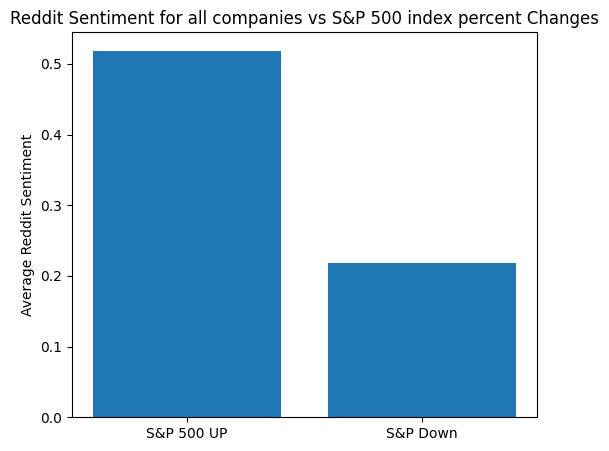

In [ ]:
all_companies_pandas_df = all_companies_daily_sentiment_df.toPandas()

avg_sent_up = all_companies_pandas_df[all_companies_pandas_df["Index Percent Change"] > 0]["all_companies_effective_sentiment"].mean()
avg_sent_down = all_companies_pandas_df[all_companies_pandas_df["Index Percent Change"] < 0]["all_companies_effective_sentiment"].mean()

plt.figure(figsize=(6,5))
plt.bar(["S&P 500 UP", "S&P Down"], [avg_sent_up, avg_sent_down])
plt.ylabel("Average Reddit Sentiment")
plt.title("Reddit Sentiment for all companies vs S&P 500 index percent Changes")
plt.show()

### Sentiment Distribution by Company

/tmp/ipython-input-1876918774.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=symbols)


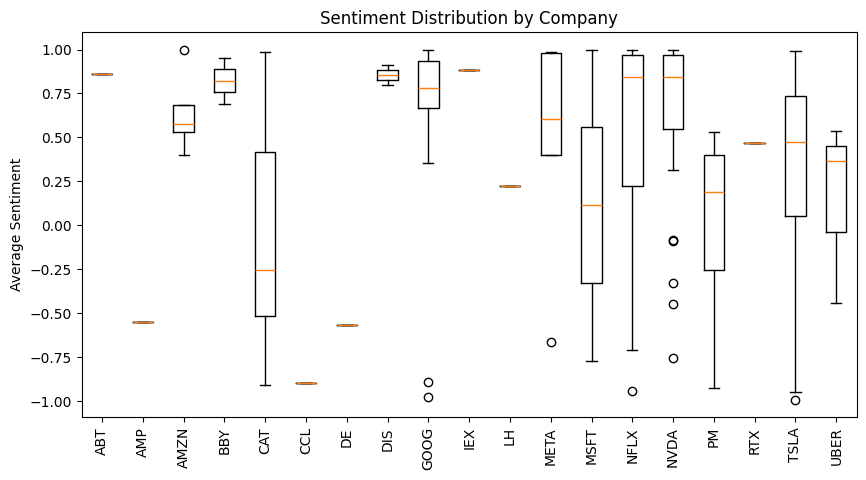

In [ ]:
symbols = pandas_reddit_stocks_df["Symbol"].unique()
data = [pandas_reddit_stocks_df[pandas_reddit_stocks_df["Symbol"] == s]["avg_sentiment"].dropna() for s in symbols]

plt.figure(figsize=(10,5))
plt.boxplot(data, labels=symbols)
plt.xticks(rotation=90)
plt.title("Sentiment Distribution by Company")
plt.ylabel("Average Sentiment")
plt.show()

### Top 10 Most Discussed S&P 500 Companies on Reddit

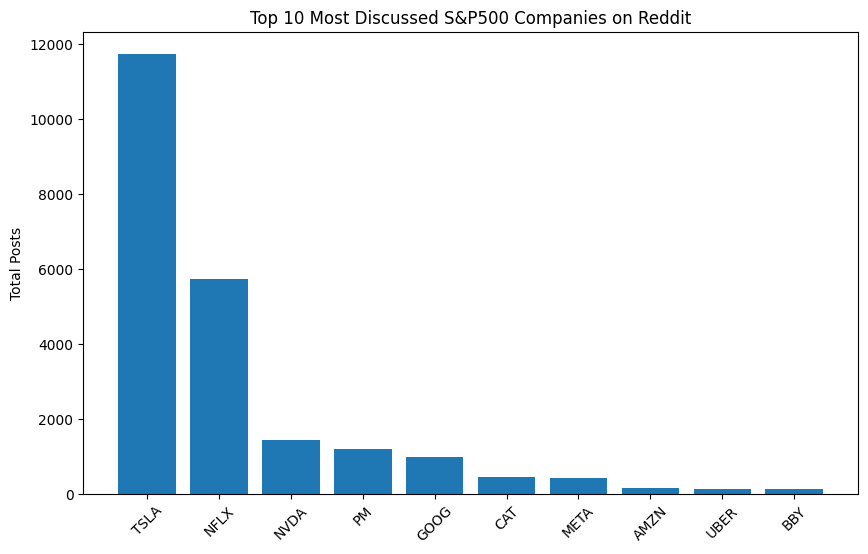

In [ ]:
ctivity = pandas_reddit_stocks_df.groupby("Symbol")["num_posts"].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,6))
plt.bar(activity.index, activity.values)
plt.title("Top 10 Most Discussed S&P500 Companies on Reddit")
plt.ylabel("Total Posts")
plt.xticks(rotation=45)
plt.show()